# Disciplines

In [1]:
from gemseo_oad_training.models import aerodynamic
from gemseo_oad_training.models import approach
from gemseo_oad_training.models import battery
from gemseo_oad_training.models import climb
from gemseo_oad_training.models import engine
from gemseo_oad_training.models import fuel_tank
from gemseo_oad_training.models import geometry
from gemseo_oad_training.models import mass
from gemseo_oad_training.models import mission
from gemseo_oad_training.models import operating_cost
from gemseo_oad_training.models import take_off
from gemseo_oad_training.models import total_mass

In [2]:
from gemseo.disciplines.auto_py import AutoPyDiscipline
discipline_aerodynamic = AutoPyDiscipline(aerodynamic)
discipline_approach = AutoPyDiscipline(approach)
discipline_battery = AutoPyDiscipline(battery)
discipline_climb = AutoPyDiscipline(climb)
discipline_engine = AutoPyDiscipline(engine)
discipline_fuel_tank = AutoPyDiscipline(fuel_tank)
discipline_geometry = AutoPyDiscipline(geometry)
discipline_mass = AutoPyDiscipline(mass)
discipline_mission = AutoPyDiscipline(mission)
discipline_operating_cost = AutoPyDiscipline(operating_cost)
discipline_take_off = AutoPyDiscipline(take_off)
discipline_total_mass = AutoPyDiscipline(total_mass)


In [3]:
disciplines = [discipline_aerodynamic,discipline_approach,discipline_battery,discipline_climb,discipline_engine,
               discipline_fuel_tank,discipline_geometry,discipline_mass,discipline_mission,discipline_operating_cost,
               discipline_take_off,discipline_total_mass]

# Design space

In [4]:
from gemseo import configure_logger
configure_logger()

<RootLogger root (INFO)>

In [5]:
from gemseo_oad_training.unit import convert_from
from gemseo.algos.parameter_space import ParameterSpace
from utils import update_default_inputs

x_def={'slst':convert_from('kN',150),'n_pax':150.0,'area':180.0,'ar':9.0,'fuel_type':'liquid_h2','engine_type':'turbofan','design_range':5500000}
update_default_inputs(disciplines,x_def)

uncertain_space = ParameterSpace()
uncertain_space.add_random_variable("gi","OTTriangularDistribution", minimum=0.35, mode=0.4, maximum=0.405)
uncertain_space.add_random_variable("vi","OTTriangularDistribution", minimum=0.755, mode=0.800, maximum=0.805)
uncertain_space.add_random_variable("aef","OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)
uncertain_space.add_random_variable("cef","OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)
uncertain_space.add_random_variable("sef","OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)

In [6]:
from gemseo import sample_disciplines
from gemseo.disciplines.surrogate import SurrogateDiscipline

training_dataset = sample_disciplines(disciplines, uncertain_space, ["tofl", "vapp","vz","span","length","fm","mtom"], algo_name="OT_MONTE_CARLO", n_samples=5000)

    INFO - 15:23:56: *** Start Sampling execution ***
    INFO - 15:23:56: Sampling
    INFO - 15:23:56:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 15:23:56:    MDO formulation: MDF
    INFO - 15:23:56: Running the algorithm OT_MONTE_CARLO:
    INFO - 15:24:36:    100%|██████████| 5000/5000 [00:39<00:00, 126.26 it/sec]
    INFO - 15:24:36: *** End Sampling execution (time: 0:00:39.997728) ***


In [7]:
import matplotlib.pyplot as plt
import pprint

In [8]:
surrogate_discipline = SurrogateDiscipline("RBFRegressor", training_dataset)

In [9]:
rmse = surrogate_discipline.get_error_measure("RMSEMeasure")
rmse.compute_learning_measure(as_dict=True)

{'fm': array([1.98671063e-16]),
 'length': array([0.]),
 'mtom': array([8.06023741e-12]),
 'span': array([0.]),
 'tofl': array([2.47053819e-13]),
 'vapp': array([5.36071414e-15]),
 'vz': array([2.00622185e-15])}

In [10]:
rmse.compute_cross_validation_measure(as_dict=True)

{'fm': array([6.36316225e-05]),
 'length': array([0.]),
 'mtom': array([2.19336095]),
 'span': array([0.]),
 'tofl': array([0.06284798]),
 'vapp': array([0.00087688]),
 'vz': array([0.00060363])}

In [11]:
from gemseo.uncertainty.statistics.empirical_statistics import EmpiricalStatistics

In [12]:
statistics = EmpiricalStatistics(training_dataset)
mean = statistics.compute_mean()
mean

{'aef': array([1.0066107]),
 'cef': array([1.0064927]),
 'fm': array([0.09907821]),
 'gi': array([0.38515354]),
 'length': array([39.75]),
 'mtom': array([76483.42983262]),
 'sef': array([1.00664097]),
 'span': array([40.24922359]),
 'tofl': array([1167.40179952]),
 'vapp': array([60.81032763]),
 'vi': array([0.78669546]),
 'vz': array([6.7804098])}

In [13]:
variance = statistics.compute_variance()
variance

{'aef': array([7.08736647e-05]),
 'cef': array([7.12377957e-05]),
 'fm': array([0.00035597]),
 'gi': array([0.00015496]),
 'length': array([0.]),
 'mtom': array([357334.69690681]),
 'sef': array([7.28066183e-05]),
 'span': array([0.]),
 'tofl': array([280.53536903]),
 'vapp': array([0.05927829]),
 'vi': array([0.00012856]),
 'vz': array([0.02665922])}

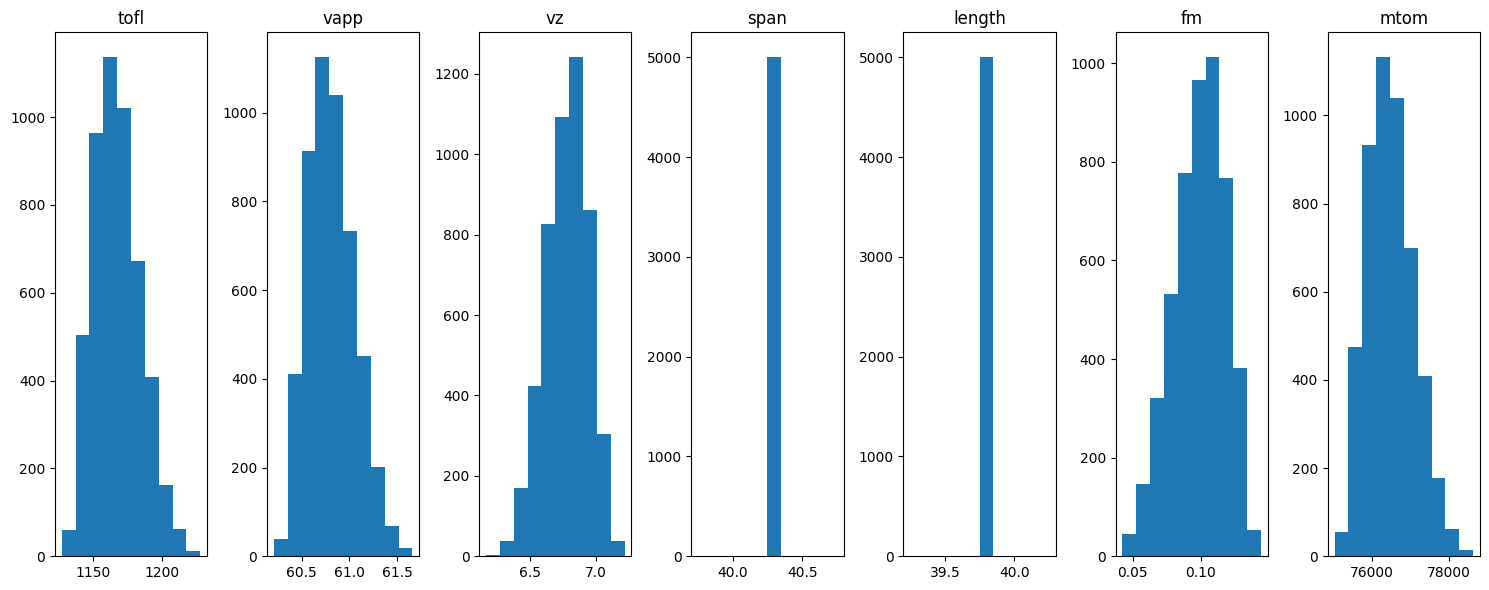

In [14]:
fig, axes = plt.subplots(1, 7,figsize=(15,6))
for ax, name in zip(axes, ["tofl", "vapp","vz","span","length","fm","mtom"]):
    ax.hist(training_dataset.get_view(variable_names=name))
    ax.set_title(name)
plt.tight_layout()
plt.show()

In [15]:
from gemseo.uncertainty.sensitivity.sobol_analysis import SobolAnalysis


In [16]:
sobol = SobolAnalysis()
sobol.compute_samples([surrogate_discipline], uncertain_space, 5000)

 WARNING - 15:24:51: No coupling in MDA, switching chain_linearize to True.
    INFO - 15:24:51: *** Start SobolAnalysisSamplingPhase execution ***
    INFO - 15:24:51: SobolAnalysisSamplingPhase
    INFO - 15:24:51:    Disciplines: RBF_Sampling
    INFO - 15:24:51:    MDO formulation: MDF
    INFO - 15:24:51: Running the algorithm OT_SOBOL_INDICES:
    INFO - 15:26:43:    100%|██████████| 4992/4992 [01:51<00:00, 44.69 it/sec]
    INFO - 15:26:43: *** End SobolAnalysisSamplingPhase execution (time: 0:01:51.981156) ***


GROUP        inputs                                           outputs         \
VARIABLE         gi        vi       aef       cef       sef        fm length   
COMPONENT         0         0         0         0         0         0      0   
0          0.394131  0.780767  1.009626  0.991074  1.016893  0.105460  39.75   
1          0.366964  0.800344  0.991988  0.992066  1.019799  0.141171  39.75   
2          0.394951  0.770859  1.009495  1.024023  1.001250  0.057498  39.75   
3          0.375284  0.795927  1.006920  1.011547  1.007358  0.106310  39.75   
4          0.375179  0.768572  1.021142  1.006022  0.993472  0.066633  39.75   
...             ...       ...       ...       ...       ...       ...    ...   
4987       0.362392  0.784477  1.020361  1.002598  1.005179  0.092768  39.75   
4988       0.373582  0.791675  1.002053  1.009646  0.998437  0.104987  39.75   
4989       0.398787  0.799326  1.021227  0.999843  1.002129  0.115983  39.75   
4990       0.399744  0.763378  1.004281  0.995392  1.014177  0.079062  39.75   
4991       0.400118  0.796594  1.007768  1.006853  1.015599  0.111781  39.75   

GROUP                                                                 
VARIABLE           mtom       span         tofl       vapp        vz  
COMPONENT             0          0            0          0         0  
0          76403.162994  40.249224  1165.092980  60.805526  6.780455  
1          77737.826508  40.249224  1202.721798  61.362661  6.553458  
2          75826.466016  40.249224  1149.037619  60.504213  6.931616  
3          77006.285834  40.249224  1182.012574  61.013685  6.643049  
4          76163.194954  40.249224  1158.396991  60.666458  6.768782  
...                 ...        ...          ...        ...       ...  
4987       77300.684975  40.249224  1190.320643  61.137878  6.482138  
4988       76660.579242  40.249224  1172.297700  60.881386  6.762853  
4989       75940.614386  40.249224  1152.205861  60.587542  6.826429  
4990       75927.818030  40.249224  1151.850405  60.607749  6.938608  
4991       76383.793002  40.249224  1164.551131  60.768230  6.797398  

[4992 rows x 12 columns]

In [17]:
sobol.compute_indices(output_names=["tofl", "vapp","vz","fm","mtom"])

SobolAnalysis.SensitivityIndices(first={'tofl': [{'gi': array([0.67804068]), 'vi': array([-0.00892309]), 'aef': array([-0.04691743]), 'cef': array([-0.04302593]), 'sef': array([0.27737656])}], 'vapp': [{'gi': array([0.6971011]), 'vi': array([-0.0062001]), 'aef': array([-0.04417921]), 'cef': array([-0.04392059]), 'sef': array([0.28393447])}], 'vz': [{'gi': array([0.58099014]), 'vi': array([0.00764144]), 'aef': array([0.08916397]), 'cef': array([-0.01747723]), 'sef': array([0.24820179])}], 'fm': [{'gi': array([-0.00921235]), 'vi': array([0.76492965]), 'aef': array([0.05802048]), 'cef': array([0.25209025]), 'sef': array([-0.00908723])}], 'mtom': [{'gi': array([0.67700951]), 'vi': array([-0.00855492]), 'aef': array([-0.04664791]), 'cef': array([-0.04282176]), 'sef': array([0.27839221])}]}, second={'tofl': [{'gi': {'gi': array([[0.]]), 'vi': array([[0.04508063]]), 'aef': array([[0.04316192]]), 'cef': array([[0.03636132]]), 'sef': array([[0.01390658]])}, 'vi': {'gi': array([[0.04508063]]), '

In [18]:
pprint.pprint(sobol.indices.first)
pprint.pprint(sobol.indices.total)

{'fm': [{'aef': array([0.05802048]),
         'cef': array([0.25209025]),
         'gi': array([-0.00921235]),
         'sef': array([-0.00908723]),
         'vi': array([0.76492965])}],
 'mtom': [{'aef': array([-0.04664791]),
           'cef': array([-0.04282176]),
           'gi': array([0.67700951]),
           'sef': array([0.27839221]),
           'vi': array([-0.00855492])}],
 'tofl': [{'aef': array([-0.04691743]),
           'cef': array([-0.04302593]),
           'gi': array([0.67804068]),
           'sef': array([0.27737656]),
           'vi': array([-0.00892309])}],
 'vapp': [{'aef': array([-0.04417921]),
           'cef': array([-0.04392059]),
           'gi': array([0.6971011]),
           'sef': array([0.28393447]),
           'vi': array([-0.0062001])}],
 'vz': [{'aef': array([0.08916397]),
         'cef': array([-0.01747723]),
         'gi': array([0.58099014]),
         'sef': array([0.24820179]),
         'vi': array([0.00764144])}]}
{'fm': [{'aef': array([0.06725228])

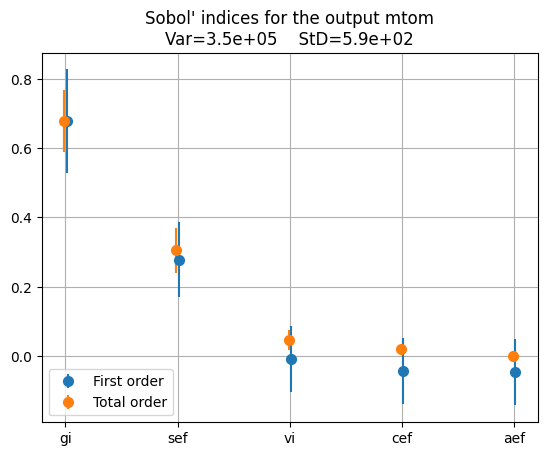

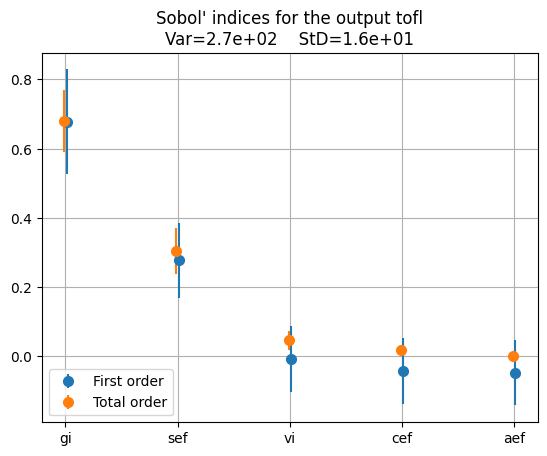

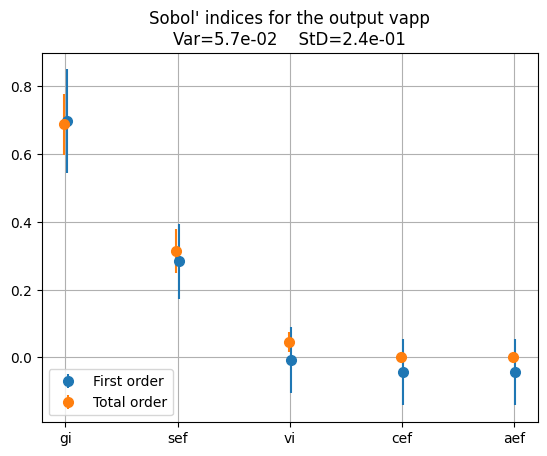

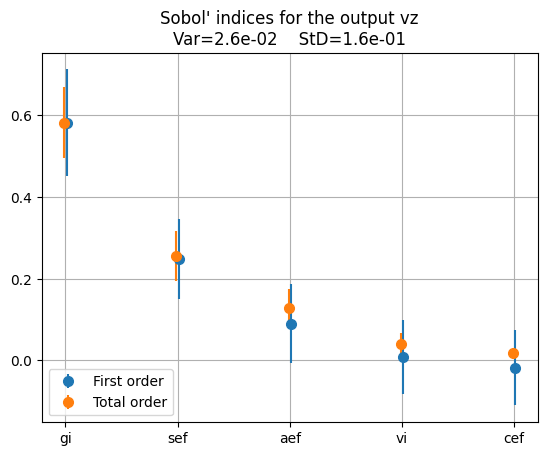

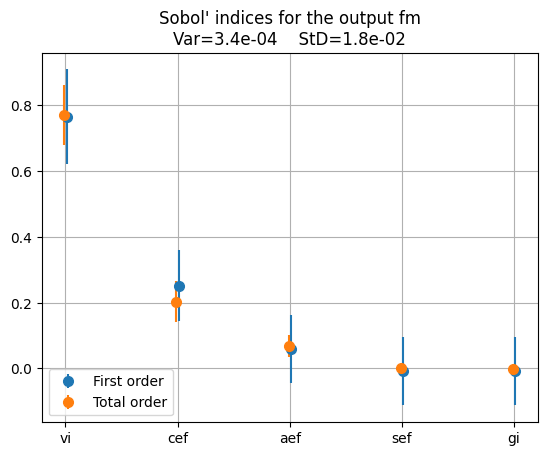

In [19]:
plt.show(sobol.plot("mtom", save=False, show=True))
plt.show(sobol.plot("tofl", save=False, show=True))
plt.show(sobol.plot("vapp", save=False, show=True))
plt.show(sobol.plot("vz", save=False, show=True))
plt.show(sobol.plot("fm", save=False, show=True))